<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
import nltk
import re
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
#data = data.drop(data.index[110000:119999])
#data = data.loc[0:50000]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
cl = data.toxic.value_counts()
display(cl)
cl[0] / cl[1]

0    143346
1     16225
Name: toxic, dtype: int64

8.834884437596301

Результаты предварительного анализа данных: 
- пропущенных данных нет
- соотношение классов неравномерное - почти 1 к 9
- текст следует лемматизировать 
- данные нужно разделить на выборки и выделить целевой признак
- получить матрицу TF-IDF

В процессе подготовки данных оказалось, что при запуске всего набора данных ядро уничтожается. В slack был совет удалить середину из набора данных. Я решила попутно сбалансировать классы: взять из второй половины данных только комменты с целевым признаком 1 и перемешать с первой половиной, взятой полностью.

Соотношение классов теперь почти 1:4. Ядро перестало вылетать, и метрика F1 улучшилась.

In [4]:
n = 70000
data = data.loc[0:n]
data.info()
cl = data.toxic.value_counts()
display(cl)
cl[0] / cl[1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70001 entries, 0 to 70000
Data columns (total 2 columns):
text     70001 non-null object
toxic    70001 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


0    62834
1     7167
Name: toxic, dtype: int64

8.76712711036696

Я попробовала осуществить лемматизацию (при помощи WordNetLemmatizer), но ее качество оставило желать лучшего. Поэтому я применила известный мне стемминг и регулярные выражения для очистки текста.

In [5]:
%%time
#стёмминг
from nltk.stem import SnowballStemmer
def stem(row):
    st = SnowballStemmer('english')
    text_list = re.sub(r'[^a-zA-Z ]', ' ', row['text'])
    clear_text = " ".join(text_list.split())
    return ' '.join([st.stem(w) for w in nltk.word_tokenize(clear_text)])

data['stemm'] = data.apply(stem, axis=1)
data.head()

CPU times: user 1min 41s, sys: 156 ms, total: 1min 41s
Wall time: 1min 42s


,text,toxic,stemm
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m realli not tri to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make ani real suggest on improv i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero ani chanc you rememb what ...


In [6]:
#разделение на выборки и отделение целевого признака
target = data['toxic']
corpus = data['stemm'].values.astype('U')

corpus_train, corpus_, target_train, target_ = train_test_split(corpus, target, test_size=0.4, random_state=42)
corpus_valid, corpus_test, target_valid, target_test = train_test_split(corpus_, target_, test_size=0.5, random_state=42)

In [7]:
#TF-IDF
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

tfidf_train = count_tf_idf.fit_transform(corpus_train)

tfidf_valid = count_tf_idf.transform(corpus_valid)
tfidf_test = count_tf_idf.transform(corpus_test)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Обучение

In [8]:
#Логистическая регрессия
model1 = LogisticRegression(random_state=42)
model1.fit(tfidf_train, target_train)
pred1 = model1.predict(tfidf_valid)
f1_score(target_valid, pred1)

0.6805125939019002

0.7458766035430666
0.7525935240490412
0.7557692307692307
0.7554259799157758
0.7571801566579635
0.7552356020942409
0.7558330594807756
9 0.7571801566579635


Text(0, 0.5, 'f1')

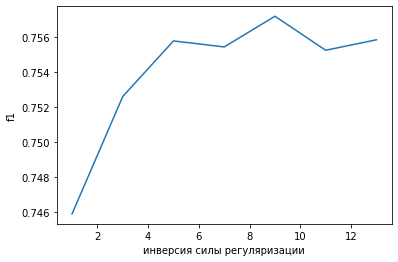

In [9]:
#Балансировка классов
c_list = []
f1_list = []
f1_min = 0
for c in range(1, 17, 2):
    
    model = LogisticRegression(random_state=42, class_weight='balanced', C=c)
    model.fit(tfidf_train, target_train)
    f1 = f1_score(target_valid, model.predict(tfidf_valid))
    
    c_list.append(c)
    f1_list.append(f1)

    if f1 > f1_min:
        f1_min = f1
        c_min = c
        
print(c_min, f1_min)    
plt.plot(c_list, f1_list)
plt.xlabel('инверсия силы регуляризации')
plt.ylabel('f1')

91 0.714231785579464


Text(0, 0.5, 'f1')

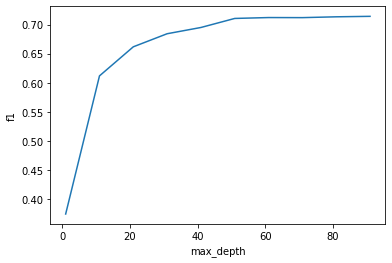

In [10]:
#Дерево
n_list = []
f1_list = []
f1_min = 0
for n in range(1, 100, 10):
    
    model = DecisionTreeClassifier(random_state=42, max_depth=n)
    model.fit(tfidf_train, target_train)
    f1 = f1_score(target_valid, model.predict(tfidf_valid))
    
    n_list.append(n)
    f1_list.append(f1)

    if f1 > f1_min:
        f1_min = f1
        n_min = n
        
print(n_min, f1_min)    
plt.plot(n_list, f1_list)
plt.xlabel('max_depth')
plt.ylabel('f1')

1 0.21961244862008222


Text(0, 0.5, 'f1')

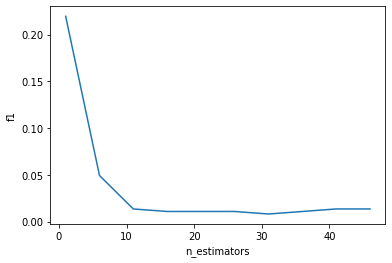

In [11]:
#Случайный лес
n_list = []
f1_list = []
f1_min = 0
for n in range(1, 50, 5):
    
    model = RandomForestClassifier(random_state=42, n_estimators=n, max_depth=20)
    model.fit(tfidf_train, target_train)
    f1 = f1_score(target_valid, model.predict(tfidf_valid))
    
    n_list.append(n)
    f1_list.append(f1)

    if f1 > f1_min:
        f1_min = f1
        n_min = n
        
print(n_min, f1_min)    
plt.plot(n_list, f1_list)
plt.xlabel('n_estimators')
plt.ylabel('f1')

91 0.4274120829576195


Text(0, 0.5, 'f1')

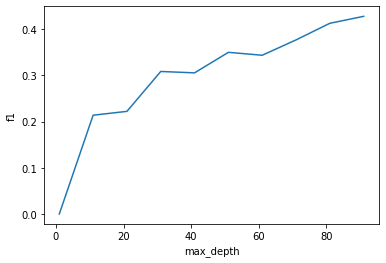

In [12]:
n_list = []
f1_list = []
f1_min = 0
for n in range(1, 100, 10):
    
    model = RandomForestClassifier(random_state=42, n_estimators=1, max_depth=n)
    model.fit(tfidf_train, target_train)
    f1 = f1_score(target_valid, model.predict(tfidf_valid))
    n_list.append(n)
    f1_list.append(f1)

    if f1 > f1_min:
        f1_min = f1
        n_min = n
        
print(n_min, f1_min)            
plt.plot(n_list, f1_list)
plt.xlabel('max_depth')
plt.ylabel('f1')

Были проверены следующие модели с различными гиперпараметрами: логистическая регрессия (с балансировкой классов и без), дерево и случайный лес.

На валидационном наборе лучше всего показала себя регрессия с балансировкой.

## Выводы

In [13]:
const = pd.Series([1]*len(target_test))
f1_0 = f1_score(target_test, const)

Так как для метрики нужный ответы 1, я построила константную модель из 1, а не 0 (хотя 0 чаще встречаются в данных). Есть ли еще способы заполнить такую модель?

In [14]:
model1 = LogisticRegression(random_state=42, class_weight='balanced', C=9.0)
model1.fit(tfidf_train, target_train)
pred1 = model1.predict(tfidf_test)
f1_1 = f1_score(target_test, pred1)

model2 = DecisionTreeClassifier(random_state=42, max_depth=50)
model2.fit(tfidf_train, target_train)
pred2 = model2.predict(tfidf_test)
f1_2 = f1_score(target_test, pred2)

model3 = RandomForestClassifier(random_state=42, n_estimators=1, max_depth=70)
model3.fit(tfidf_train, target_train)
pred3 = model3.predict(tfidf_test)
f1_3 = f1_score(target_test, pred3)

In [15]:
columns = ['Модель', 'f1']
name = ['Константная модель', 'Линейная регрессия', 'Дерево', 'Случайный лес']
f1 = [f1_0, f1_1, f1_2, f1_3]
results = pd.DataFrame([name, f1], columns)
display(results)

,0,1,2,3
Модель,Константная модель,Линейная регрессия,Дерево,Случайный лес
f1,0.188979,0.77258,0.719782,0.392892


Такие значения метрики получились для первой половины датасета (с 0 до 70000) без изменений в соотношении классов. Если я брала больше 80000, ядро каждый раз умирало.

    	Константная модель	Линейная регрессия	Дерево	Случайный лес

    f1  0.188979	          0.754648	          0.71978   0.392892
    
    

**Вывод**

В ходе данной работы была решена задача классификации комментариев на позитивные и негативные. Модели были обучены на наборе данных с разметкой о токсичности правок.

Данные были подготовлены при помощи стёмминга и регулярных выражений. Классы, изначальное соотношение которых было около 1 к 9, были сбалансированы за счет того, что от второй половины данных были оставлены только представители положительного класса. Далее была получена матрица TF-IDF для сбалансированного набора данных.

Были обучены и протестированы следующие модели с различными гиперпараметрами: логистическая регрессия (с балансировкой классов и без), дерево и случайный лес. Сравнение проводилось по метрике F1. Полученные результаты для всех моделей превышают значение метрики константной модели. Лучшей моделью оказалась логистическая регрессия с балансировкой классов, показавшая значение метрики 